# Sentinel-2 multispectral imagery
### Does the modeled surface water (ponded water) match what is seen from multispectral imagery?

!!! need to get the files from download_S2.ipynb to actually export the right format (should be a mask with one band, not 4)

In [1]:
import mikeio
import matplotlib.pyplot as plt
import geopandas as gpd
import tools

<Axes: >

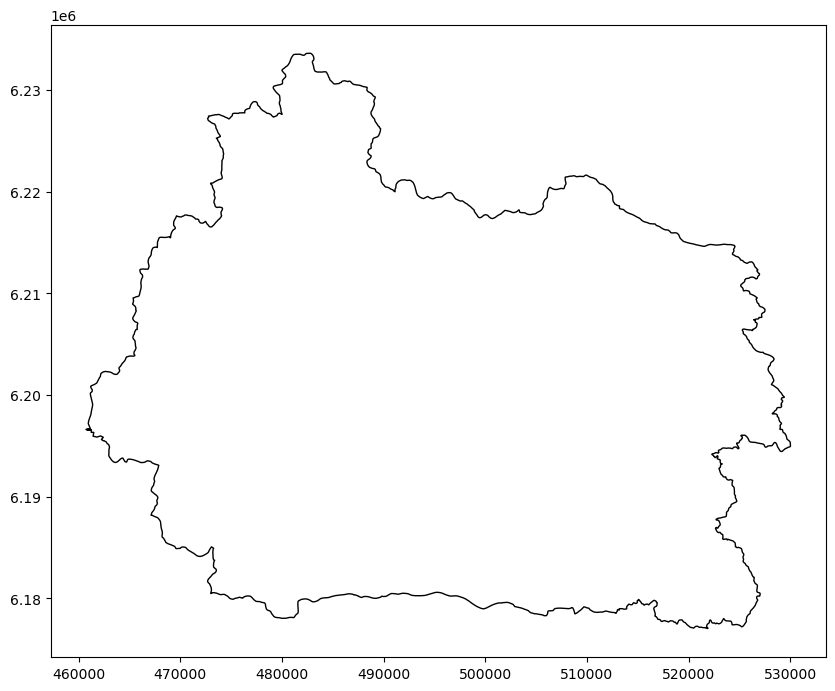

In [2]:
# Domain data
fig, ax = plt.subplots(figsize=(10, 10))
domain_shp = gpd.read_file( r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")
domain_shp.plot(facecolor='none', edgecolor='black',ax=ax)


In [48]:
import rasterio
from rasterio.transform import xy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

def plot_mask_with_boundary(tif_path, shapefile_path):
    # Read shapefile
    gdf = gpd.read_file(shapefile_path)

    # Read raster
    with rasterio.open(tif_path) as src:
        mask = src.read(1)  # first band
        transform = src.transform
        raster_crs = src.crs

    # Mask NaNs or zeros (optional, for water mask display)
    mask = np.where(mask == 0, np.nan, mask)

    # Reproject shapefile to raster CRS
    gdf_proj = gdf.to_crs(raster_crs)

    # Create coordinate mesh for plotting
    rows, cols = np.meshgrid(np.arange(mask.shape[0]), np.arange(mask.shape[1]), indexing='ij')
    xs, ys = xy(transform, rows, cols)

    # Convert xs, ys from 2D arrays to extent for imshow
    extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(mask, cmap="Blues", extent=extent, origin='upper')
    gdf_proj.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)
    plt.colorbar(im, ax=ax, label="Water Mask Value")
    plt.title("Water Mask with Boundary")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()
    return mask, gdf_proj



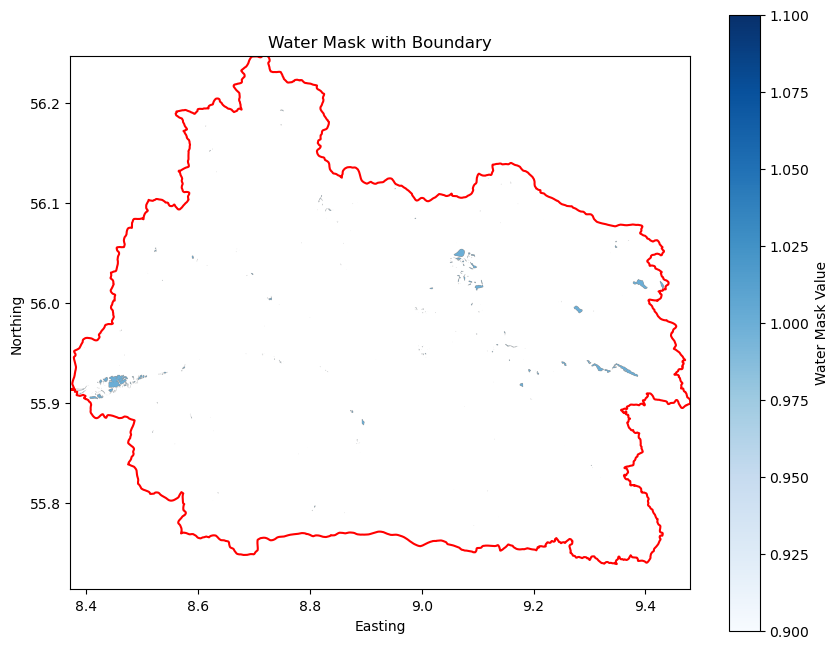

In [50]:
# Example usage
path = r"..\MS\S2_WaterMask_skjern_0419.tif"

rastermask, boundary = plot_mask_with_boundary(path, r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")

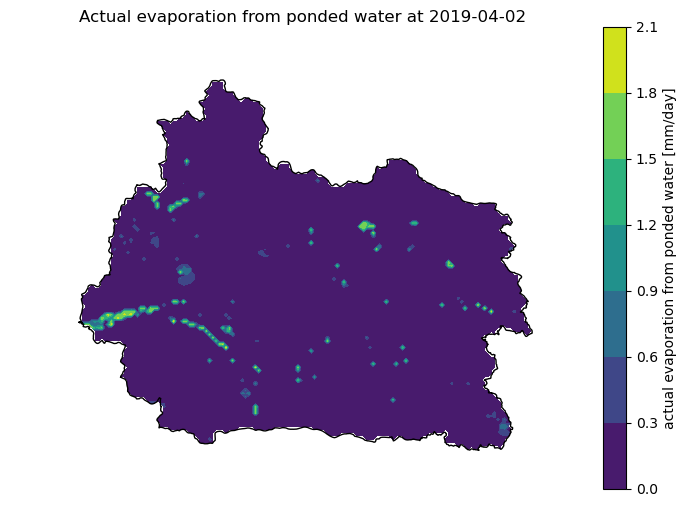

In [4]:
# Load in MIKESHE results for ponded water evaporation (i.e. ponded water extent)

tools.plot_dfs2_output(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_ET_UzCells.dfs2", varname='actual evaporation from ponded water', timeID=763, ax=None, shapefile=domain_shp)

OWevt_dfs2 = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_ET_UzCells.dfs2")
varname='actual evaporation from ponded water'
timeID = 763  # selected time step
OWevt_dfs2 = OWevt_dfs2[varname][timeID]
test = OWevt_dfs2.to_xarray()

df = test.to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    df[varname], geometry=gpd.points_from_xy(df.x,df.y))

# rename varname to 'OWTD'
gdf.rename(columns={varname: 'evt'}, inplace=True)

# export geodataframe to shapefile
gdf.crs = "EPSG:32632"  # EPSG for UTM 32N (WGS 84)
#gdf.to_file(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\evt_ponded_water.shp")


In [ ]:
# Compare location of ponded water evaporation with water mask -  compute spatial correlation and distance error